In [1]:
%matplotlib inline
from functools import lru_cache
import os
import numpy as np
import scipy.io.wavfile
import scipy.fftpack
import scipy.linalg
import matplotlib.pyplot as plt

In [2]:
COMMANDS = '../input/speech-recognition/audio'
VALIDATION = '../input/speech-recognition/validation'
TEST = '../input/speech-recognition/test'
SPOKEN_DIGIT = '../input/speech-recognition/free-spoken-digit-dataset/recordings'

In [3]:
commands10x10 = []
for root, dirs, files in os.walk(COMMANDS):
    for name in files:
        filename = os.path.join(root, name)
        command = root.split('/')[-1]
        speaker = name.split('_')[0]
        commands10x10.append({
            'wav': filename,
            'text': command,
            'speaker': speaker
        })
print(commands10x10[-1])

{'wav': '../input/speech-recognition/audio/five/0132a06d_nohash_0.wav', 'text': 'five', 'speaker': '0132a06d'}


In [4]:
commands10x100 = []
for root, dirs, files in os.walk(VALIDATION):
    for name in files:
        filename = os.path.join(root, name)
        command = root.split('/')[-1]
        speaker = name.split('_')[0]
        commands10x100.append({
            'wav': filename,
            'text': command,
            'speaker': speaker
        })
print(commands10x100[-1])

{'wav': '../input/speech-recognition/validation/validation/five/8dc18a75_nohash_0.wav', 'text': 'five', 'speaker': '8dc18a75'}


In [5]:
free10x4x4 = []
SPEAKERS = ['jackson', 'nicolas', 'theo', 'yweweler']
N_DIGITS = 10
N_REPETITIONS = 4
for digit in range(N_DIGITS):
    for speaker in SPEAKERS:
        for repetition in range(N_REPETITIONS):
            free10x4x4.append({
                'wav': f'{SPOKEN_DIGIT}/{digit}_{speaker}_{repetition}.wav',
                'text': str(digit),
                'speaker': speaker
            })
print(free10x4x4[-1])

{'wav': '../input/speech-recognition/free-spoken-digit-dataset/recordings/9_yweweler_3.wav', 'text': '9', 'speaker': 'yweweler'}


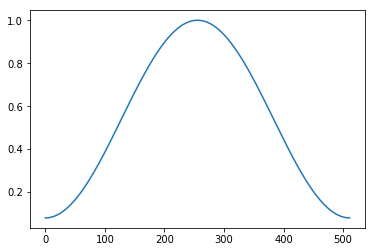

In [6]:
# Hamming window
@lru_cache(maxsize=10)
def get_window(n, type='hamming'):
    coefs = np.arange(n)
    window = 0.54 - 0.46 * np.cos(2 * np.pi * coefs / (n - 1))
    return window
plt.plot(get_window(512))

In [7]:
# Preemphasis filter
def apply_preemphasis(y, preemCoef=0.97):
    y[1:] = y[1:] - preemCoef*y[:-1]
    y[0] *= (1 - preemCoef)
    return y

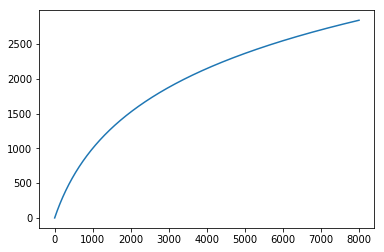

In [8]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)
plt.plot(freq_to_mel(np.arange(8000)))

In [9]:
def mel_to_freq(mels):
    return 700.0 * (np.power(10.0, mels / 2595.0) - 1.0)

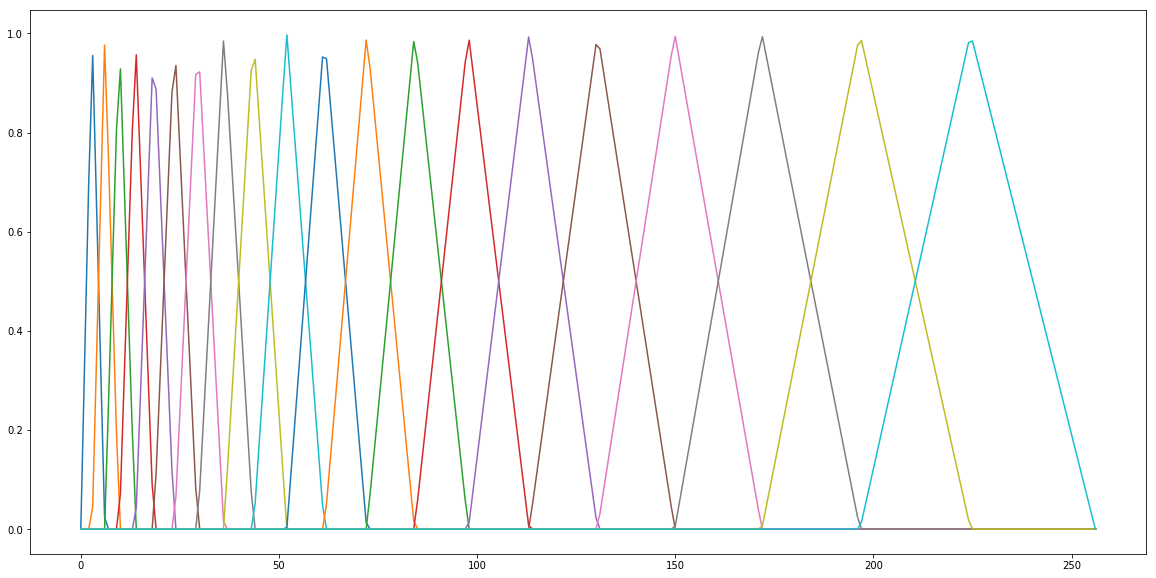

In [10]:
@lru_cache(maxsize=10)
def get_filterbank(numfilters, filterLen, lowFreq, highFreq, samplingFreq):
    minwarpfreq = freq_to_mel(lowFreq)
    maxwarpfreq = freq_to_mel(highFreq)
    dwarp = (maxwarpfreq - minwarpfreq) / (numfilters + 1)
    f = mel_to_freq(np.arange(numfilters + 2) * dwarp + minwarpfreq) * (filterLen - 1) * 2.0 / samplingFreq
    i = np.arange(filterLen)[None, :]
    f = f[:, None]
    hislope = (i - f[:numfilters]) / (f[1:numfilters+1] - f[:numfilters])
    loslope = (f[2:numfilters+2] - i) / (f[2:numfilters+2] - f[1:numfilters+1])
    H = np.maximum(0, np.minimum(hislope, loslope))
    return H
H = get_filterbank(numfilters=20, filterLen=257, lowFreq=0, highFreq=8000, samplingFreq=16000)
fig = plt.figure(figsize=(20,10))
for h in H:
  plt.plot(h)

In [11]:
def normalized(y, threshold=0):
    y -= y.mean()
    stddev = y.std()
    if stddev > threshold:
        y /= stddev
    return y

In [12]:
def mfsc(y, sfr, window_size=0.025, window_stride=0.010, window='hamming', normalize=False, log=True, n_mels=20, preemCoef=0, melfloor=1.0):
    win_length = int(sfr * window_size)
    hop_length = int(sfr * window_stride)
    n_fft = 512
    lowfreq = 0
    highfreq = sfr/2
    
    # get window
    window = get_window(win_length)
    padded_window = np.pad(window, (0, n_fft - win_length), mode='constant')[:, None]
    
    # preemphasis
    y = apply_preemphasis(y.copy(), preemCoef)

    # scale wave signal
    y *= 32768
    
    # get frames
    num_frames = 1 + (len(y) - win_length) // hop_length
    pad_after = num_frames*hop_length + (n_fft - hop_length) - len(y)
    if pad_after > 0:
        y = np.pad(y, (0, pad_after), mode='constant')
    frames = np.lib.stride_tricks.as_strided(y, shape=(n_fft, num_frames), strides=(y.itemsize, hop_length * y.itemsize), writeable=False)
    windowed_frames = padded_window * frames
    D = np.abs(np.fft.rfft(windowed_frames, axis=0))

    # mel filterbank
    filterbank = get_filterbank(n_mels, n_fft/2 + 1, lowfreq, highfreq, sfr)
    mf = np.dot(filterbank, D)
    mf = np.maximum(melfloor, mf)
    if log:
        mf = np.log(mf)
    if normalize:
        mf = normalized(mf)

    return mf

In [13]:
def mfsc2mfcc(S, n_mfcc=12, dct_type=2, norm='ortho', lifter=22, cms=True, cmvn=True):
    # Discrete Cosine Transform
    M = scipy.fftpack.dct(S, axis=0, type=dct_type, norm=norm)[:n_mfcc]

    # Ceptral mean subtraction (CMS) 
    if cms or cmvn:
        M -= M.mean(axis=1, keepdims=True)

    # Ceptral mean and variance normalization (CMVN)
    if cmvn:
        M /= M.std(axis=1, keepdims=True)
    
    # Liftering
    elif lifter > 0:
        lifter_window = 1 + (lifter / 2) * np.sin(np.pi * np.arange(1, 1 + n_mfcc, dtype=M.dtype) / lifter)[:, np.newaxis]
        M *= lifter_window

    return M

In [14]:
from IPython.display import Audio
Audio(filename=free10x4x4[0]['wav'], autoplay=True)

Plot two examples

../input/speech-recognition/free-spoken-digit-dataset/recordings/0_jackson_0.wav Sampling frequency:  8000
../input/speech-recognition/free-spoken-digit-dataset/recordings/0_jackson_1.wav Sampling frequency:  8000


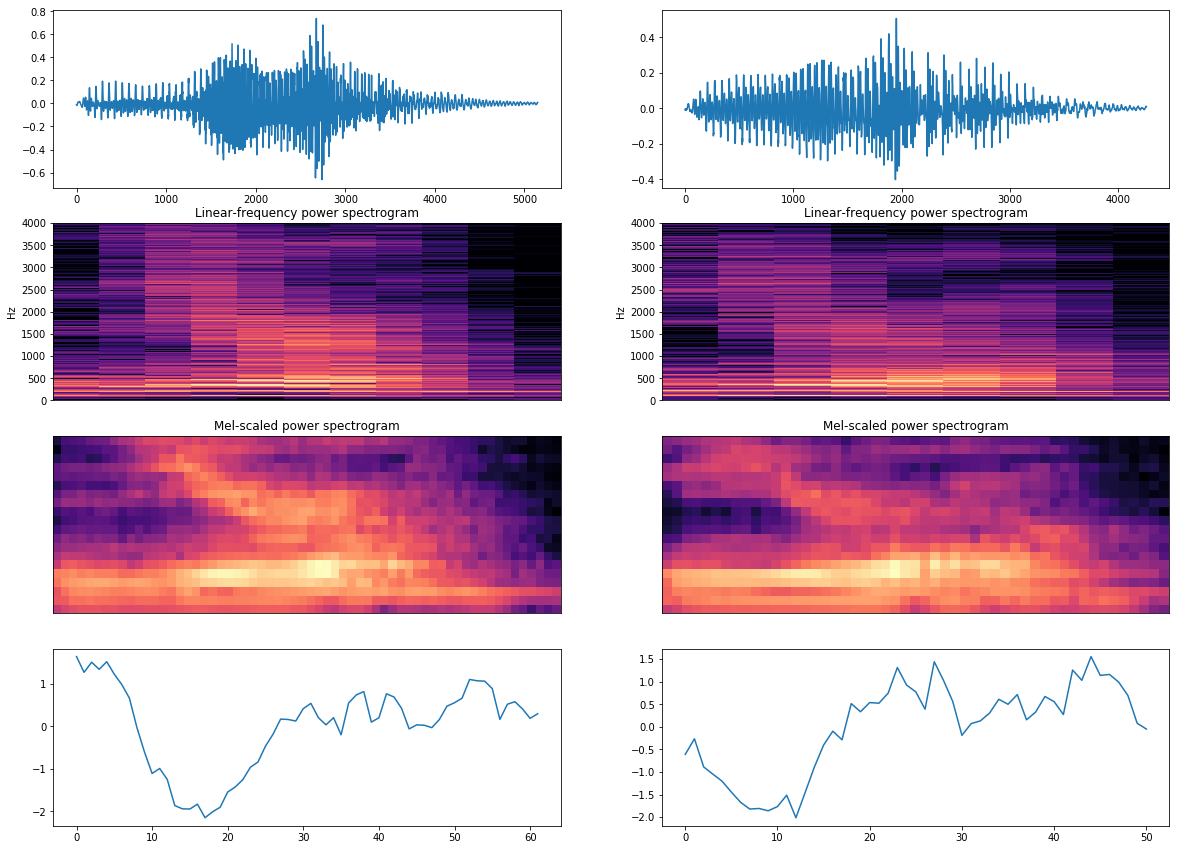

In [15]:
import librosa
import librosa.display
fig = plt.figure(figsize=(20,15))
for i in range(2):
    wav = free10x4x4[i]['wav']
    sfr, y = scipy.io.wavfile.read(wav)
    y = y/32768
    print(wav, 'Sampling frequency: ', sfr)
    fig = plt.subplot(4,2,i+1)
    plt.plot(y)

    # Liner frequency spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    fig = plt.subplot(4,2,i+3)
    librosa.display.specshow(D, y_axis='linear', sr=sfr)
    plt.title('Linear-frequency power spectrogram')

    # Mel-scaled spectrogram (20 bank filters)
    S = mfsc(y, sfr)
    fig = plt.subplot(4,2,i+5)
    librosa.display.specshow(S - S.min())
    plt.title('Mel-scaled power spectrogram')

    # MFCC(5)
    M = mfsc2mfcc(S)
    fig = plt.subplot(4,2,i+7)
    plt.plot(M[1,:])

Fast DTW version using scipy.spatial.distance.cdist to compute distance and numba (compiled python)

In [16]:
from numba import jit
@jit
def dtw(x, y, dist='sqeuclidean'):
  """
  Computes Dynamic Time Warping (DTW) of two sequences.
  :param array x: N1*M array
  :param array y: N2*M array
  :param func dist: distance used as cost measure
  """
  r, c = len(x), len(y)

  D = np.zeros((r + 1, c + 1))
  D[0, 1:] = np.inf
  D[1:, 0] = np.inf

  D[1:, 1:] = scipy.spatial.distance.cdist(x, y, dist)

  for i in range(r):
    for j in range(c):
      min_prev = min(D[i, j], D[i+1, j], D[i, j+1])
      # D[i+1, j+1] = dist(x[i], y[j]) + min_prev
      D[i+1, j+1] += min_prev

  '''
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D)
    return D[-1, -1], path
  '''

  return D[-1, -1]

In [17]:
# Do not show numba warnings
import warnings
from numba.errors import NumbaWarning
warnings.simplefilter("ignore", category=NumbaWarning)

In [18]:
a = np.array([1,4,4,5,9,3,1,8,8], dtype=np.float32)[:,np.newaxis]
b = np.array([1,2,3,8,8,3,1,8], dtype=np.float32)[:,np.newaxis]
dtw(a, b, dist='sqeuclidean')

9.0

In [19]:
# Compute MFCC
def get_mfcc(dataset, n_mfcc=12, **kwargs):
    mfccs = []
    for sample in dataset:
        sfr, y = scipy.io.wavfile.read(sample['wav'])
        y = y/32768
        S = mfsc(y, sfr, **kwargs)
        M = mfsc2mfcc(S, n_mfcc).T
        # DM = delta(M)
        # M = np.hstack((M, DM))
        mfccs.append(M.astype(np.float32))
    return mfccs

In [20]:
# Word Error Rate (Accuracy)
def wer(test_dataset, ref_dataset=None, same_spk=False, n_mfcc=12, compare='text'):
    # Compute mfcc
    test_mfcc = get_mfcc(test_dataset, n_mfcc)
    if ref_dataset is None:
        ref_dataset = test_dataset
        ref_mfcc = test_mfcc
    else:
        ref_mfcc = get_mfcc(ref_dataset, n_mfcc)
        
    err = 0
    for i, test in enumerate(test_dataset):
        mincost = np.inf
        minref = None
        for j, ref in enumerate(ref_dataset):
            if not same_spk and test['speaker'] == ref['speaker']:
                # Do not compare with refrence recordings of the same speaker
                continue
            if test['wav'] != ref['wav']:
                distance = dtw(test_mfcc[i], ref_mfcc[j])
                if distance < mincost:
                    mincost = distance
                    minref = ref
        if test[compare] != minref[compare]:
            err += 1

    wer = 100*err/len(test_dataset)
    return wer

In [21]:
# Free Spoken Digit Dataset
print(f'WER including reference recordings from the same speaker: {wer(free10x4x4, same_spk=True, n_mfcc=22):.1f}%')

WER including reference recordings from the same speaker: 6.9%


In [22]:
# Google Speech Commands Dataset (small digit subset)
print(f'WER using only reference recordings from other speakers: {wer(commands10x100, commands10x10, n_mfcc=5):.1f}%')

WER using only reference recordings from other speakers: 27.5%


In [23]:
test_wavs = []
for filename in os.listdir(TEST):
    test_wavs.append({
        'wav': TEST + '/' + filename
    })

In [24]:
def test(test_wavs, ref_wavs, n_mfcc=11):
    pred = []
    test_mfccs = get_mfcc(test_wavs, n_mfcc)
    ref_mfccs = get_mfcc(ref_wavs, n_mfcc)
    for i in range(len(test_mfccs)):
        mincost = np.inf
        jmin = -1
        for j in range(len(ref_mfccs)):
            distance = dtw(test_mfccs[i], ref_mfccs[j])
            if distance < mincost:
                mincost = distance
                jmin = j
        pred.append(ref_wavs[jmin]['text'])
        if i<10:
            print(f'{i:3}/{len(test_mfccs)}: {pred[i]}')
    return pred

In [25]:
pred = test(test_wavs, commands10x10 + commands10x100, 10)

  0/1000: eight
  1/1000: seven
  2/1000: eight
  3/1000: six
  4/1000: nine
  5/1000: five
  6/1000: eight
  7/1000: six
  8/1000: two
  9/1000: three


In [26]:
with open('submission.csv', 'w') as f:
    print('filename,command', file=f)
    for entry, command in zip(test_wavs, pred):
        filename = entry['wav'].split('/')[-1].split('.')[0]
        print(f'{filename},{command}', file=f)